# Data Science Master Class
# Prognozowanie tygodniowej sprzedaży na rok do przodu.

💡 Data Science Master Class to cykl dla osób, które znają już podstawowe narzędzia Data Science & Machine Learnig, ale chcą nauczyć się, jak wykorzystwać je w praktyce i na prawdziwych danych lub podnieść poziom swoich praktycznych umiejętności. 

### Podczas data science master class uczymy się w ramach zdrowej grywalizacji i konkursu na Kaggle 🤖 

Konkurs będzie dostępny na Kaggle - link do [konkursu](https://www.kaggle.com/t/dde03996c8804dbd94baaf41c610c681).

#### 💪 Celem tej inicjatywy jest możliwość wypracowania umiejętności samodzielnej pracy nad rozwiązywaniem konkretnego problemu oraz dobra zabawa :) 

#### 👉 Poza tym budujesz swoje portfolio 🤗 


## Zadanie: **Prognozowanie sprzedaży tygodniowej na rok do przodu** 


Naszym zadaniem będzie zbudować model, który prognozuje dla każdego sklepu tygodniową sprzedaż używając danych historycznych. 


## Metryka sukcesu


Metryką sukcesu w tym zadaniu będzie: `MAE` (taka metryka jest ustawiona na Kaggle i według takiej metryki sukcesu będzie przeliczany Twój wynik). 


*Mówiąc po ludzku, metryka sukcesu to sposób mierzenia, jaki ma błąd model. Daje nam to też możliwość jednoznacznie porównać np. model A i model B. Natomiast trzeba od razu zrozumieć, że nie ma idealnej metryki (każda z nich ma wady), ale są takie, które mogą być przydatne w danym konteście (zadaniu).* 


## Dane


### Sales

Historyczne dane sprzedaży:

- `store` - numer sklepu (sklep zawiera jeden lub więcej oddziałów)
- `dept` - numer oddziału
- `date` - tydzień (dane są zebrane w tygodniowe grupy)
- `weekly_sales` -  sprzedaż dla danego działu w danym sklepie
- `is_holiday` - czy tydzień jest specjalnym tygodniem (świątecznym)

### Cechy (dodatkowe informacje zewnętrzne)
Zawierają dodatkowe dane związane ze sklepem, działem i aktywnością regionalną w podanych terminach.

- `store` - the store number,
- `date` - tydzień (dane są zebrane w tygodniowe grupy),
- `temperature` - średnia temperatura w regionie,
- `fuel_price` - koszt paliwa w regionie,
- `mark_down1-5` - zanonimizowane dane związane z promocyjnymi obniżkami cen. Dane `mark_down` są dostępne dopiero po listopadzie 2011 i nie są dostępne dla wszystkich sklepów przez cały czas. Wszelkie brakujące wartości są oznaczone NA.
- `cpi` - indeks cen konsumpcyjnych (ang. `the consumer price index`),
- `unemployment` - stopa bezrobocia,
- `is_holiday` - czy tydzień jest specjalnym tygodniem świątecznym. 

### Store

Dodatkowo jeszcze mamy informacę o rodzaju oraz wielkości sklepu.

## ✔️ Wczytujemy biblioteki

In [1]:
import pickle
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (15, 5)
import seaborn as sns

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
import lightgbm as lgb

import eli5
from eli5.sklearn import PermutationImportance

from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit
from sklearn.metrics import mean_absolute_error

import optuna

## ✔️ Wczytujemy dane

In [2]:
df_sales_train = pd.read_hdf("../input/sales_train.h5")
df_sales_train['is_train'] = True
df_sales_test  = pd.read_hdf("../input/sales_test.h5")
df_sales_test['is_train'] = False
df_sales = pd.concat([df_sales_train, df_sales_test])
df_sales.sample(5)

,id,weekly_sales,store,dept,date,is_holiday,is_train
6990,6990,23116.890625,31,10,30/09/2011,False,True
389551,389551,NaN,35,95,12/10/2012,False,False
314146,314146,1430.000000,13,48,13/05/2011,False,True
418427,418427,0.500000,28,18,14/05/2010,False,True
372470,372470,3500.000000,31,58,08/10/2010,False,True


In [3]:
df_sales.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 421570 entries, 1 to 421569
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            421570 non-null  int32  
 1   weekly_sales  285089 non-null  float32
 2   store         421570 non-null  int8   
 3   dept          421570 non-null  int8   
 4   date          421570 non-null  object 
 5   is_holiday    421570 non-null  bool   
 6   is_train      421570 non-null  bool   
dtypes: bool(2), float32(1), int32(1), int8(2), object(1)
memory usage: 11.3+ MB


In [4]:
df_features_train = pd.read_hdf("../input/features_train.h5")
df_features_test = pd.read_hdf("../input/features_test.h5")
df_features = pd.concat([df_features_train, df_features_test])
df_features.sample(5)

,store,date,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday
7646,43,19/02/2010,9.320312,2.513672,NaN,NaN,NaN,NaN,NaN,203.250,9.523438,False
392,3,20/08/2010,31.125000,2.664062,NaN,NaN,NaN,NaN,NaN,214.875,7.347656,False
4415,25,31/12/2010,-3.394531,3.179688,NaN,NaN,NaN,NaN,NaN,204.625,7.484375,True
8046,45,29/10/2010,16.281250,2.921875,NaN,NaN,NaN,NaN,NaN,182.875,8.726562,False
3549,20,04/11/2011,6.601562,3.550781,NaN,NaN,NaN,NaN,NaN,210.875,7.082031,False


In [5]:
df_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8190 entries, 0 to 8189
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   store         8190 non-null   int8   
 1   date          8190 non-null   object 
 2   temperature   4365 non-null   float16
 3   fuel_price    4365 non-null   float16
 4   mark_down1    220 non-null    float16
 5   mark_down2    182 non-null    float16
 6   mark_down3    214 non-null    float16
 7   mark_down4    184 non-null    float16
 8   mark_down5    225 non-null    float16
 9   cpi           4365 non-null   float16
 10  unemployment  4365 non-null   float16
 11  is_holiday    8190 non-null   bool   
dtypes: bool(1), float16(9), int8(1), object(1)
memory usage: 287.9+ KB


In [6]:
df_store = pd.read_csv("../input/stores_data.csv")
df_store.columns = ["store", "store_type", "store_size"]
df_store.sample(5)

,store,store_type,store_size
23,24,A,203819
26,27,A,204184
4,5,B,34875
6,7,B,70713
14,15,B,123737


In [7]:
df_store.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45 entries, 0 to 44
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   store       45 non-null     int64 
 1   store_type  45 non-null     object
 2   store_size  45 non-null     int64 
dtypes: int64(2), object(1)
memory usage: 1.2+ KB


### Jedna ramka danych

In [8]:
df = df_sales.merge(df_features, how='left', on=['date', 'store'])
df = df.merge(df_store, how='left', on=['store'])

In [9]:
# test
df.shape[0] == df_sales.shape[0]

True

In [10]:
df.sample(5)

,id,weekly_sales,store,dept,date,is_holiday_x,is_train,temperature,fuel_price,mark_down1,mark_down2,mark_down3,mark_down4,mark_down5,cpi,unemployment,is_holiday_y,store_type,store_size
167158,247270,25201.550781,32,10,14/10/2011,False,True,10.085938,3.490234,NaN,NaN,NaN,NaN,NaN,195.00,8.515625,False,A,203007
291629,20094,NaN,17,56,09/03/2012,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,B,93188
115021,170472,2050.870117,40,44,29/07/2011,False,True,19.687500,3.898438,NaN,NaN,NaN,NaN,NaN,136.00,4.585938,False,A,155083
308267,71335,NaN,39,71,24/08/2012,False,False,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,False,A,184109
226802,335415,32545.599609,2,7,09/04/2010,False,True,18.562500,2.769531,NaN,NaN,NaN,NaN,NaN,210.25,8.203125,False,A,202307


Pozostaje jedynie zweryfikować kolumnę `is_holiday`.

In [11]:
# wartości spójne
df[['is_holiday_x', 'is_holiday_y']].drop_duplicates()

,is_holiday_x,is_holiday_y
0,False,False
4,True,True


In [12]:
df['is_holiday'] = df['is_holiday_x']
df = df.drop(columns=['is_holiday_x', 'is_holiday_y'])

## 🎯 Zmienna docelowa

`weekly_sales` -> `weekly_sales_log1p`


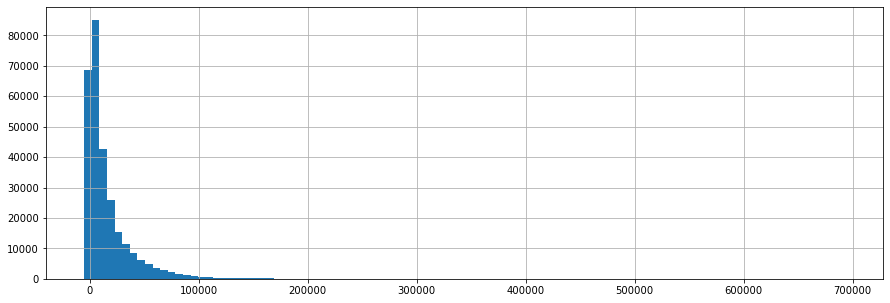

In [13]:
df[df.is_train]["weekly_sales"].hist(bins=100);

Zazwyczaj ceny, a w szczególności sumy kwot mają rozkłady mocno skośne. Decyduję się na zlogarytmowanie zmiennej docelowej aby uzyskać rozkład bardziej symetryczny. Jedyne co muszę sprawdzić to jaką część zbioru mają wartości mniejsze od 1 (a szczególnie ujemne, bo ich nie możemy logarytmować).

In [14]:
# min, max, procent ujemnych, procent mniejszych od 1, suma mniejszych od 1
df["weekly_sales"][~df["weekly_sales"].isna()].\
agg([min, max, 
     lambda x: len([y for y in x if y < 0])/len(x),
     lambda x: sum([y for y in x if y < 0]),
     lambda x: len([y for y in x if y < 1])/len(x),
     lambda x: sum([y for y in x if y < 1]),
     lambda x: abs(sum([y for y in x if y < 0]))/sum([y for y in x if y > 0]),])

min          -4988.939941
max         693099.375000
<lambda>         0.002925
<lambda>    -60979.779899
<lambda>         0.004286
<lambda>    -60834.999898
<lambda>         0.000013
Name: weekly_sales, dtype: float64

Rekordy z wartościami mniejszymi od 1 to zaledwie 0.4% całego zbioru uczącego. Stanowi to prawie zerowy udział w całej kwocie. Tym samym nową zmienną docelową staje się `weekly_sales_log1p` (jako `ln(1+x)`).

In [15]:
df['weekly_sales_log1p'] = df["weekly_sales"].map(lambda x: 0 if x < 0 else np.log1p(x))

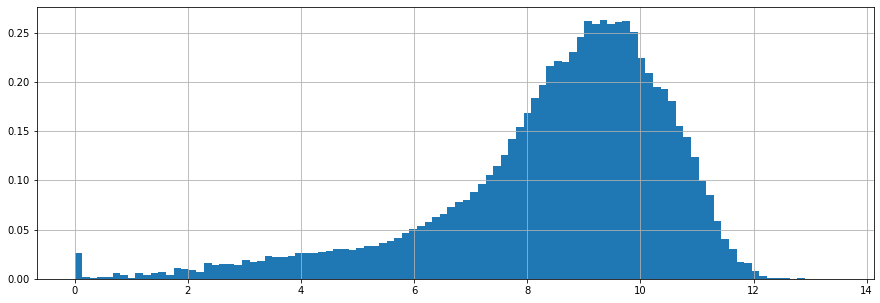

In [16]:
df[df.is_train]["weekly_sales_log1p"].hist(bins=100, density=1);

## Data analysis

Nie mam za bardzo na to czasu. Model pracy jest taki: połączenie danych, oczyszczenie, feature engineering, feature selection, wybranie "na oko" najlepszej metody, parameters optimization.

## Feature engineering

### date

In [17]:
# konwertuję to formatu datetime
df['date_dt'] = pd.to_datetime(df['date'], dayfirst=True)

In [18]:
# Uwaga na daty!
df['date_dt_invalid'] = pd.to_datetime(df['date'])
df[['date', 'date_dt', 'date_dt_invalid']][df['date_dt'] != df['date_dt_invalid']]

,date,date_dt,date_dt_invalid
0,09/07/2010,2010-07-09,2010-09-07
2,10/06/2011,2011-06-10,2011-10-06
4,10/09/2010,2010-09-10,2010-10-09
10,05/11/2010,2010-11-05,2010-05-11
11,02/12/2011,2011-12-02,2011-02-12
...,...,...,...
421550,05/10/2012,2012-10-05,2012-05-10
421556,03/02/2012,2012-02-03,2012-03-02
421557,04/05/2012,2012-05-04,2012-04-05
421561,01/06/2012,2012-06-01,2012-01-06


In [19]:
# sprawdzam, czy dane treningowe nie nachodzą na dane testowe
df.groupby('is_train').date_dt.agg([min, max]).reset_index()

,is_train,min,max
0,False,2011-12-16,2012-10-26
1,True,2010-02-05,2011-12-09


In [20]:
# wyciągam rok, miesiąc i tydzień
df['year'] = df['date_dt'].dt.year
df['month'] = df['date_dt'].dt.month
df['week'] = df['date_dt'].dt.week

In [21]:
# na potrzeby analizy danych historycznych dodaję zmienną year_prev
df['year_prev'] = df['year'] - 1

### is_holiday

Sprawdzam wpływ zmiennej na wartości tygodniowe.

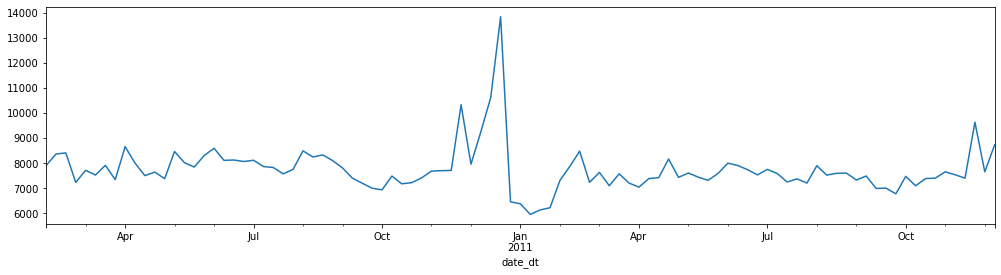

In [22]:
df[df.is_train].groupby('date_dt').weekly_sales.median().plot(figsize=(17,4));

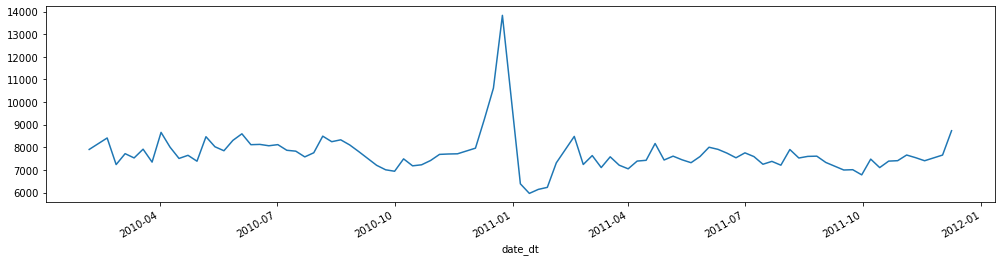

In [23]:
df[df.is_train & ~df.is_holiday].groupby('date_dt').weekly_sales.median().plot(figsize=(17,4));

Coś jest nie tak w moim rozumieniu tej zmiennej - pominęliśmy okres bożonarodzeniowy? Nie znając dokładnych założeń zmiennej staram się to naprawić po swojemu.

In [24]:
# w oparciu o poprzednie, holiday rozumiemy jako "czas zwiększonego zapotrzebowania na zakupy"
# także w tym rozumieniu pierwszy tydzień roku nie jest świętem (bo jemy zapasy, i zaciskamy pasa po świętach)
# ostatnie dwa tygodnie roku natomiast jak najbardziej są
df['is_holiday_fixed'] = df['is_holiday']
df.loc[df['date'].isin(['31/12/2010', '30/12/2011']), 'is_holiday_fixed'] = False
df.loc[df['date'].isin(['17/12/2010', '24/12/2010', '16/12/2011', '23/12/2011']), 'is_holiday_fixed'] = True

In [25]:
# jakie to dni?
set(df[df.is_holiday_fixed]['date']).intersection(set(df[~df.is_holiday_fixed]['date']))
set(df[df.is_holiday_fixed].sort_values('date_dt')['date_dt'])

{Timestamp('2010-02-12 00:00:00'),
 Timestamp('2010-09-10 00:00:00'),
 Timestamp('2010-11-26 00:00:00'),
 Timestamp('2010-12-17 00:00:00'),
 Timestamp('2010-12-24 00:00:00'),
 Timestamp('2011-02-11 00:00:00'),
 Timestamp('2011-09-09 00:00:00'),
 Timestamp('2011-11-25 00:00:00'),
 Timestamp('2011-12-16 00:00:00'),
 Timestamp('2011-12-23 00:00:00'),
 Timestamp('2012-02-10 00:00:00'),
 Timestamp('2012-09-07 00:00:00')}

In [26]:
# wygląda na to, że są 4 okresy - dodaję nową zmienną
# ~ 10 luty
# ~ 10 wrzesień
# ~ 25 listopad (black friday)
# ~ 16 + 24 grudzień
df['holiday_fixed_cat'] = df.apply(lambda x: 0 if x['is_holiday_fixed'] is False else x['month'], axis=1)
df['holiday_fixed_cat'] = df['holiday_fixed_cat'].map({0:0, 2: 1, 9: 2, 11: 3, 12: 4})

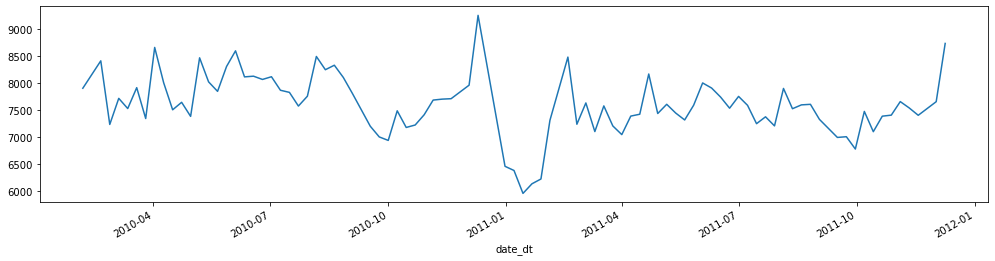

In [27]:
# teraz to wygląda dużo lepiej
df[df.is_train & ~df.is_holiday_fixed].groupby('date_dt').weekly_sales.median().plot(figsize=(17,4));

In [28]:
# widać wyróżniające się tygodnie pod koniec roku
# min, max, mediana, średnia, suma w mln
df[df.is_train].groupby('holiday_fixed_cat').weekly_sales.agg([min, max, np.median, np.mean, lambda x: sum(x)/1000000])

,min,max,median,mean,<lambda_0>
holiday_fixed_cat,,,,,
0,-4988.939941,293966.062500,7573.879883,15647.725586,4090.722412
1,-500.000000,222651.015625,8111.915039,16232.248047,95.672867
2,-598.000000,214448.953125,7437.779785,15673.897461,92.397629
3,-169.979996,693099.375000,10007.379883,22220.945312,132.414612
4,-372.899994,406988.625000,11986.839844,24133.933594,142.752213


In [29]:
# nie zapominam o wyjątkowym początku roku (można byłoby to też dodać do holiday_fixed_cat)
df['is_new_year'] = False
df.loc[df['date'].isin(['31/12/2010', '30/12/2011']), 'is_new_year'] = True

In [30]:
# a może to coś da?
df['is_december'] = False
df.loc[df['holiday_fixed_cat'].isin([3, 4]), 'is_december'] = True

In [31]:
# zgodnie z przypuszczeniami, sprzedaż jest znacznie niższa
# min, max, mediana, średnia, suma w mln
df[df.is_train & ~df.is_holiday_fixed].groupby('is_new_year').weekly_sales.agg([min, max, np.median, np.mean, lambda x: sum(x)/1000000])

,min,max,median,mean,<lambda_0>
is_new_year,,,,,
False,-4988.939941,293966.06250,7583.310059,15669.462891,4050.289795
True,-698.000000,147532.15625,6462.160156,13738.538086,40.432518


In [32]:
# jeszcze is_black_friday
df['is_black_friday'] = False
df.loc[df['holiday_fixed_cat'].isin([2]), 'is_black_friday'] = True

### store + dept

Staram się znaleźć coś ciekawego o sklepach i oddziałach.

In [33]:
# dodaję oddział id
df['store_dept'] = df['store'].map(lambda x: x*100) + df['dept']

In [34]:
# walidacyjnie
# czy jeden oddział ma dwa rekordy na tydzień? NIE
df.groupby(['store_dept', 'date']).id.count().reset_index().sort_values('id').tail(1)

,store_dept,date,id
421569,4598,31/12/2010,1


In [35]:
# store_type na int
df['store_type_cat'] = df['store_type'].map({'A': 0, 'B': 1, 'C': 2}).fillna(-1)
df['store_type_cat'].value_counts()

0    215478
1    163495
2     42597
Name: store_type_cat, dtype: int64

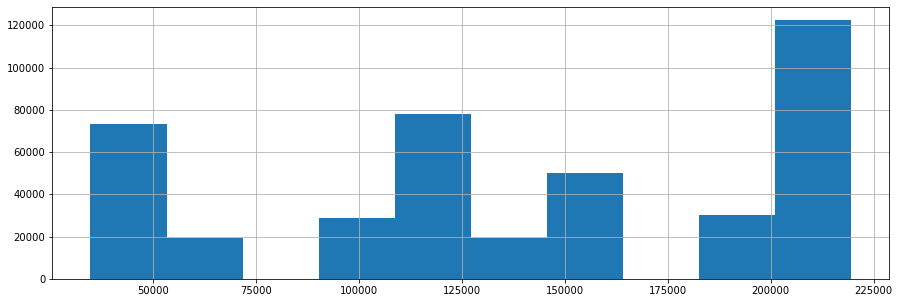

In [36]:
# store size_cat
df['store_size'].hist();

In [37]:
df['store_size_cat'] = df['store_size'].map(lambda x: 0 if x < 75000 else 2 if x > 175000 else 1)

In [38]:
# ile sklepów, numerów oddziałów oraz różnych oddziałów?
df['store'].unique().shape[0], df['dept'].unique().shape[0], df['store_dept'].unique().shape[0]

(45, 81, 3331)

In [39]:
# liczba sklepów per rok
df[['year', 'store']].drop_duplicates().groupby('year').count()

,store
year,
2010,45
2011,45
2012,45


In [40]:
# liczba oddziałów w danym roku
df[['year', 'store_dept']].drop_duplicates().groupby('year').count()

,store_dept
year,
2010,3197
2011,3245
2012,3216


Być może będzie to można wykorzystać, dlatego tworzę zmienne typu: liczba oddziałów ogółem w danym roku, miesiącu, czy tygodniu.

In [41]:
temp1 = df[['year', 'store', 'dept']].drop_duplicates().groupby(['year', 'store']).count().reset_index().rename(columns={'dept': 'dept_yr_cnt'})
temp2 = df[['year', 'month', 'store', 'dept']].drop_duplicates().groupby(['year', 'month', 'store']).count().reset_index().rename(columns={'dept': 'dept_mo_cnt'})
temp3 = df[['year', 'week', 'store', 'dept']].drop_duplicates().groupby(['year', 'week', 'store']).count().reset_index().rename(columns={'dept': 'dept_wk_cnt'})
df = df.merge(temp1, how='left', on=['year', 'store'])
df = df.merge(temp2, how='left', on=['year', 'store', 'month'])
df = df.merge(temp3, how='left', on=['year', 'store', 'week'])

Jeszcze z uwzględnieniem store_type.

In [42]:
temp1 = df[['year', 'store_dept', 'store_type']].drop_duplicates().groupby(['year', 'store_type']).count().reset_index().rename(columns={'store_dept': 'dept_store_type_yr_cnt'})
temp2 = df[['year', 'month', 'store_dept', 'store_type']].drop_duplicates().groupby(['year', 'month', 'store_type']).count().reset_index().rename(columns={'store_dept': 'dept_store_type_mo_cnt'})
temp3 = df[['year', 'week', 'store_dept', 'store_type']].drop_duplicates().groupby(['year', 'week', 'store_type']).count().reset_index().rename(columns={'store_dept': 'dept_store_type_wk_cnt'})
df = df.merge(temp1, how='left', on=['year', 'store_type'])
df = df.merge(temp2, how='left', on=['year', 'store_type', 'month'])
df = df.merge(temp3, how='left', on=['year', 'store_type', 'week'])

### dane historyczne

Na początek obliczam statystyki wybranych zmiennych na dany okres.

#### weekly_sales

In [43]:
def zero_cnt(data):
    return len([x for x in data if x <= 0])

In [44]:
# monthly_sales dla store_dept
temp_m_sd = df.groupby(['store_dept', 'year', 'month']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'monthly_sales_store_dept_min', 
                'nanmax': 'monthly_sales_store_dept_max',
                'nansum': 'monthly_sales_store_dept_sum',
                'nanmean': 'monthly_sales_store_dept_mean',
                'nanmedian': 'monthly_sales_store_dept_median',
                'nanstd': 'monthly_sales_store_dept_std',
                'size': 'monthly_sales_store_dept_size',
                'zero_cnt': 'monthly_sales_store_dept_zero_cnt'})

# weekly_sales dla store
temp_w_s = df.groupby(['store', 'year', 'week']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'weekly_sales_store_min', 
                'nanmax': 'weekly_sales_store_max',
                'nansum': 'weekly_sales_store_sum',
                'nanmean': 'weekly_sales_store_mean',
                'nanmedian': 'weekly_sales_store_median',
                'nanstd': 'weekly_sales_store_std',
                'size': 'weekly_sales_store_size',
                'zero_cnt': 'weekly_sales_store_zero_cnt'})

# monthly_sales dla store
temp_m_s = df.groupby(['store', 'year', 'month']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'monthly_sales_store_min', 
                'nanmax': 'monthly_sales_store_max',
                'nansum': 'monthly_sales_store_sum',
                'nanmean': 'monthly_sales_store_mean',
                'nanmedian': 'monthly_sales_store_median',
                'nanstd': 'monthly_sales_store_std',
                'size': 'monthly_sales_store_size',
                'zero_cnt': 'monthly_sales_store_zero_cnt'})

# weekly_sales dla store_type_cat
temp_w_st = df.groupby(['store_type_cat', 'year', 'week']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'weekly_sales_store_type_min', 
                'nanmax': 'weekly_sales_store_type_max',
                'nansum': 'weekly_sales_store_type_sum',
                'nanmean': 'weekly_sales_store_type_mean',
                'nanmedian': 'weekly_sales_store_type_median',
                'nanstd': 'weekly_sales_store_type_std',
                'size': 'weekly_sales_store_type_size',
                'zero_cnt': 'weekly_sales_store_type_zero_cnt'})

# monthly_sales dla store_type_cat
temp_m_st = df.groupby(['store_type_cat', 'year', 'month']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'monthly_sales_store_type_min', 
                'nanmax': 'monthly_sales_store_type_max',
                'nansum': 'monthly_sales_store_type_sum',
                'nanmean': 'monthly_sales_store_type_mean',
                'nanmedian': 'monthly_sales_store_type_median',
                'nanstd': 'monthly_sales_store_type_std',
                'size': 'monthly_sales_store_type_size',
                'zero_cnt': 'monthly_sales_store_type_zero_cnt'})

# weekly_sales dla store_size_cat
temp_w_ss = df.groupby(['store_size_cat', 'year', 'week']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'weekly_sales_store_size_min', 
                'nanmax': 'weekly_sales_store_size_max',
                'nansum': 'weekly_sales_store_size_sum',
                'nanmean': 'weekly_sales_store_size_mean',
                'nanmedian': 'weekly_sales_store_size_median',
                'nanstd': 'weekly_sales_store_size_std',
                'size': 'weekly_sales_store_size_size',
                'zero_cnt': 'weekly_sales_store_size_zero_cnt'})

# monthly_sales dla store_size_cat
temp_m_ss = df.groupby(['store_size_cat', 'year', 'month']).weekly_sales.agg([np.nanmin, np.nanmax, np.nansum, np.nanmean, np.nanmedian, np.nanstd, np.size, zero_cnt]).reset_index().\
rename(columns={'nanmin': 'monthly_sales_store_size_min', 
                'nanmax': 'monthly_sales_store_size_max',
                'nansum': 'monthly_sales_store_size_sum',
                'nanmean': 'monthly_sales_store_size_mean',
                'nanmedian': 'monthly_sales_store_size_median',
                'nanstd': 'monthly_sales_store_size_std',
                'size': 'monthly_sales_store_size_size',
                'zero_cnt': 'monthly_sales_store_size_zero_cnt'})

df = df.merge(temp_m_sd, how='left', on=['store_dept', 'year', 'month'])
df = df.merge(temp_w_s, how='left', on=['store', 'year', 'week'])
df = df.merge(temp_m_s, how='left', on=['store', 'year', 'month'])
df = df.merge(temp_w_st, how='left', on=['store_type_cat', 'year', 'week'])
df = df.merge(temp_m_st, how='left', on=['store_type_cat', 'year', 'month'])
df = df.merge(temp_w_ss, how='left', on=['store_size_cat', 'year', 'week'])
df = df.merge(temp_m_ss, how='left', on=['store_size_cat', 'year', 'month'])

Tam gdzie wydaje się, że ma to sens tworzę zmienną: jaka była wartość w analogicznym okresie, ale rok temu.

In [45]:
# tutaj chyba jedyny sens może mieć weekly_sales oraz temperature z uwagi na sezonowość
# nie jestem pewien co do innych, czy przypadkiem tutaj sporego wpływu nie ma też czas - szczególnie paliwo
for c in ['weekly_sales', 'temperature', 'fuel_price', 
          'mark_down1', 'mark_down2', 'mark_down3', 'mark_down4', 'mark_down5', 
          'cpi', 'unemployment']:
    # xxx dla store_dept ale rok temu
    temp = df[['year', 'week', 'store_dept', c]].rename(columns={'year': 'year_prev', c: f'{c}_store_dept_year_prev'})
    df = df.merge(temp, how='left', on=['year_prev', 'week', 'store_dept'])

In [46]:
for t in ['weekly', 'monthly']:
    tt = 'week' if t == 'weekly' else 'month'
    for c in ['store_dept', 'store', 'store_type', 'store_size']:
        if  (t != 'weekly') | (c != 'store_dept'):
            for s in ['min', 'max', 'sum', 'mean', 'median', 'std', 'size', 'zero_cnt']:
                temp = df[['year', tt, c, f'{t}_sales_{c}_{s}']].drop_duplicates().\
                rename(columns={'year': 'year_prev', 
                                f'{t}_sales_{c}_{s}': f'{t}_sales_{c}_{s}_year_prev'})
                df = df.merge(temp, how='left', on=['year_prev', tt, c])

Jeszcze tylko logarytmy na zmiennych skośnych.

In [47]:
for c in [x for x in df.columns if ('_sales_' in x) & (x != 'weekly_sales') & (x != 'weekly_sales_log1p')]:
    df[f'{c}_log1p'] = df[c].map(lambda x: 0 if x < 0 else np.log1p(x))

## Feature selection

In [48]:
target = 'weekly_sales_log1p'

In [49]:
# wszystkie zmienne, które mogą mieć sens
feats_all = [
    'year',
    'month',
    'week',
    'store',
    'dept',
    'store_dept',
    'store_type_cat',
    'store_size',
    'store_size_cat',
    'holiday_fixed_cat',
    'is_holiday_fixed',
    'is_new_year',
    'is_december',
    'is_black_friday',
    'dept_yr_cnt',
    'dept_mo_cnt',
    'dept_wk_cnt',
    'dept_store_type_yr_cnt',
    'dept_store_type_mo_cnt',
    'dept_store_type_wk_cnt',
#     'weekly_sales_store_dept_year_prev',
#     'temperature_store_dept_year_prev',
#     'fuel_price_store_dept_year_prev',
#     'mark_down1_store_dept_year_prev',
#     'mark_down2_store_dept_year_prev',
#     'mark_down3_store_dept_year_prev',
#     'mark_down4_store_dept_year_prev',
#     'mark_down5_store_dept_year_prev',
#     'cpi_store_dept_year_prev',
#     'unemployment_store_dept_year_prev',
#     'weekly_sales_store_min_year_prev',
#     'weekly_sales_store_max_year_prev',
#     'weekly_sales_store_sum_year_prev',
#     'weekly_sales_store_mean_year_prev',
#     'weekly_sales_store_median_year_prev',
#     'weekly_sales_store_std_year_prev',
#     'weekly_sales_store_size_year_prev',
#     'weekly_sales_store_zero_cnt_year_prev',
#     'weekly_sales_store_type_min_year_prev',
#     'weekly_sales_store_type_max_year_prev',
#     'weekly_sales_store_type_sum_year_prev',
#     'weekly_sales_store_type_mean_year_prev',
#     'weekly_sales_store_type_median_year_prev',
#     'weekly_sales_store_type_std_year_prev',
#     'weekly_sales_store_type_size_year_prev',
#     'weekly_sales_store_type_zero_cnt_year_prev',
#     'weekly_sales_store_size_min_year_prev',
#     'weekly_sales_store_size_max_year_prev',
#     'weekly_sales_store_size_sum_year_prev',
#     'weekly_sales_store_size_mean_year_prev',
#     'weekly_sales_store_size_median_year_prev',
#     'weekly_sales_store_size_std_year_prev',
#     'weekly_sales_store_size_size_year_prev',
#     'weekly_sales_store_size_zero_cnt_year_prev',
#     'monthly_sales_store_dept_min_year_prev',
#     'monthly_sales_store_dept_max_year_prev',
#     'monthly_sales_store_dept_sum_year_prev',
#     'monthly_sales_store_dept_mean_year_prev',
#     'monthly_sales_store_dept_median_year_prev',
#     'monthly_sales_store_dept_std_year_prev',
#     'monthly_sales_store_dept_size_year_prev',
#     'monthly_sales_store_dept_zero_cnt_year_prev',
#     'monthly_sales_store_min_year_prev',
#     'monthly_sales_store_max_year_prev',
#     'monthly_sales_store_sum_year_prev',
#     'monthly_sales_store_mean_year_prev',
#     'monthly_sales_store_median_year_prev',
#     'monthly_sales_store_std_year_prev',
#     'monthly_sales_store_size_year_prev',
#     'monthly_sales_store_zero_cnt_year_prev',
#     'monthly_sales_store_type_min_year_prev',
#     'monthly_sales_store_type_max_year_prev',
#     'monthly_sales_store_type_sum_year_prev',
#     'monthly_sales_store_type_mean_year_prev',
#     'monthly_sales_store_type_median_year_prev',
#     'monthly_sales_store_type_std_year_prev',
#     'monthly_sales_store_type_size_year_prev',
#     'monthly_sales_store_type_zero_cnt_year_prev',
#     'monthly_sales_store_size_min_year_prev',
#     'monthly_sales_store_size_max_year_prev',
#     'monthly_sales_store_size_sum_year_prev',
#     'monthly_sales_store_size_mean_year_prev',
#     'monthly_sales_store_size_median_year_prev',
#     'monthly_sales_store_size_std_year_prev',
#     'monthly_sales_store_size_size_year_prev',
#     'monthly_sales_store_size_zero_cnt_year_prev',
    'weekly_sales_store_dept_year_prev_log1p',
    'weekly_sales_store_min_year_prev_log1p',
    'weekly_sales_store_max_year_prev_log1p',
    'weekly_sales_store_sum_year_prev_log1p',
    'weekly_sales_store_mean_year_prev_log1p',
    'weekly_sales_store_median_year_prev_log1p',
    'weekly_sales_store_std_year_prev_log1p',
    'weekly_sales_store_size_year_prev_log1p',
    'weekly_sales_store_zero_cnt_year_prev_log1p',
    'weekly_sales_store_type_min_year_prev_log1p',
    'weekly_sales_store_type_max_year_prev_log1p',
    'weekly_sales_store_type_sum_year_prev_log1p',
    'weekly_sales_store_type_mean_year_prev_log1p',
    'weekly_sales_store_type_median_year_prev_log1p',
    'weekly_sales_store_type_std_year_prev_log1p',
    'weekly_sales_store_type_size_year_prev_log1p',
    'weekly_sales_store_type_zero_cnt_year_prev_log1p',
    'weekly_sales_store_size_min_year_prev_log1p',
    'weekly_sales_store_size_max_year_prev_log1p',
    'weekly_sales_store_size_sum_year_prev_log1p',
    'weekly_sales_store_size_mean_year_prev_log1p',
    'weekly_sales_store_size_median_year_prev_log1p',
    'weekly_sales_store_size_std_year_prev_log1p',
    'weekly_sales_store_size_size_year_prev_log1p',
    'weekly_sales_store_size_zero_cnt_year_prev_log1p',
    'monthly_sales_store_dept_min_year_prev_log1p',
    'monthly_sales_store_dept_max_year_prev_log1p',
    'monthly_sales_store_dept_sum_year_prev_log1p',
    'monthly_sales_store_dept_mean_year_prev_log1p',
    'monthly_sales_store_dept_median_year_prev_log1p',
    'monthly_sales_store_dept_std_year_prev_log1p',
    'monthly_sales_store_dept_size_year_prev_log1p',
    'monthly_sales_store_dept_zero_cnt_year_prev_log1p',
    'monthly_sales_store_min_year_prev_log1p',
    'monthly_sales_store_max_year_prev_log1p',
    'monthly_sales_store_sum_year_prev_log1p',
    'monthly_sales_store_mean_year_prev_log1p',
    'monthly_sales_store_median_year_prev_log1p',
    'monthly_sales_store_std_year_prev_log1p',
    'monthly_sales_store_size_year_prev_log1p',
    'monthly_sales_store_zero_cnt_year_prev_log1p',
    'monthly_sales_store_type_min_year_prev_log1p',
    'monthly_sales_store_type_max_year_prev_log1p',
    'monthly_sales_store_type_sum_year_prev_log1p',
    'monthly_sales_store_type_mean_year_prev_log1p',
    'monthly_sales_store_type_median_year_prev_log1p',
    'monthly_sales_store_type_std_year_prev_log1p',
    'monthly_sales_store_type_size_year_prev_log1p',
    'monthly_sales_store_type_zero_cnt_year_prev_log1p',
    'monthly_sales_store_size_min_year_prev_log1p',
    'monthly_sales_store_size_max_year_prev_log1p',
    'monthly_sales_store_size_sum_year_prev_log1p',
    'monthly_sales_store_size_mean_year_prev_log1p',
    'monthly_sales_store_size_median_year_prev_log1p',
    'monthly_sales_store_size_std_year_prev_log1p',
    'monthly_sales_store_size_size_year_prev_log1p',
    'monthly_sales_store_size_zero_cnt_year_prev_log1p'
]

In [50]:
len(feats_all)

77

**Jak sobie radzą startery?**

In [51]:
feats_all_cut = [x for x in feats_all if not any([y in x for y in ['_min_', '_max_', '_sum_', '_median_', '_std_', '_size_l', '_zero_']])]

df_train = df[df.is_train].copy()
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

X = df_train[feats_all_cut].fillna(-1)
y = df_train[target]

df_test = df[~df.is_train].copy()
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test = df_test[feats_all_cut].fillna(-1)
X_test= X_test.reset_index(drop=True)

In [54]:
# model = DecisionTreeRegressor(max_depth=10)
# model.fit(X, y)

# df_test['weekly_sales'] = model.predict(X_test)
# df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))
# df_test[ ["id", "weekly_sales"] ].to_csv("../output/starters_decision_tree.csv", index=False)

In [55]:
# model = RandomForestRegressor()
# model.fit(X, y)

# df_test['weekly_sales'] = model.predict(X_test)
# df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))
# df_test[ ["id", "weekly_sales"] ].to_csv("../output/starters_random_forest.csv", index=False)

In [56]:
# model = xgb.XGBRegressor()
# model.fit(X, y)

# df_test['weekly_sales'] = model.predict(X_test)
# df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))
# df_test[ ["id", "weekly_sales"] ].to_csv("../output/starters_xgb.csv", index=False)

In [57]:
# model = lgb.LGBMRegressor()
# model.fit(X, y, feature_name=feats_all_cut)

# df_test['weekly_sales'] = model.predict(X_test)
# df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))
# df_test[ ["id", "weekly_sales"] ].to_csv("../output/starters_lgb.csv", index=False)

**Czy może być lepiej? LightGB**

### ELI5

In [58]:
df_train = df[df.is_train].copy()
df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

X = df_train[feats_all].fillna(-1)
y = df_train[target]

In [59]:
# model = lgb.LGBMRegressor()
# model.fit(X, y, feature_name=feats_all)

# imp = PermutationImportance(model, random_state=2022, cv=ShuffleSplit(n_splits=3)).fit(X, y)

# eli5_weights = eli5.show_weights(imp, feature_names=feats_all, top=100)
# eli5_weights_table = pd.read_html(eli5_weights.data)[0].loc[:99,]
# eli5_weights_table['w'] = eli5_weights_table['Weight'].map(lambda x: np.float(x.split(' ')[0]) + np.float(x.split(' ')[-1]))
# eli5_weights_table = eli5_weights_table[eli5_weights_table.w > 0.001]
# eli5_weights

In [60]:
# feats_eli = list(eli5_weights_table.sort_values('w', ascending=False)['Feature'][:30])
# feats_eli

In [61]:
feats_eli = [
    'dept',
    'weekly_sales_store_min_year_prev_log1p',
    'weekly_sales_store_dept_year_prev_log1p',
    'store_size',
    'monthly_sales_store_dept_mean_year_prev_log1p',
    'weekly_sales_store_max_year_prev_log1p',
    'weekly_sales_store_type_zero_cnt_year_prev_log1p',
    'weekly_sales_store_sum_year_prev_log1p',
    'store_dept',
    'monthly_sales_store_dept_min_year_prev_log1p',
    'week',
    'dept_yr_cnt',
    'store',
    'store_type_cat',
    'year',
    'monthly_sales_store_dept_sum_year_prev_log1p',
    'weekly_sales_store_mean_year_prev_log1p',
    'weekly_sales_store_median_year_prev_log1p',
    'monthly_sales_store_dept_median_year_prev_log1p',
    'monthly_sales_store_size_year_prev_log1p',
    'weekly_sales_store_size_size_year_prev_log1p',
    'dept_store_type_wk_cnt',
    'store_size_cat',
    'monthly_sales_store_type_std_year_prev_log1p',
    'dept_store_type_yr_cnt',
    'dept_wk_cnt',
    'monthly_sales_store_max_year_prev_log1p',
    'monthly_sales_store_std_year_prev_log1p',
    'dept_mo_cnt',
    'weekly_sales_store_size_year_prev_log1p'
]

### Parameters Optimization

In [62]:
X = X[feats_eli]

In [63]:
# def objective(trial, X=X, y=y, test_size=0.2):
#     train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=2022)
    
#     param = {
#         'metric': 'mae', 
#         'random_state': 2022,
#         'n_estimators': 500,
#         'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-3, 10.0),
#         'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-3, 10.0),
#         'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.3,0.4,0.5,0.6,0.7,0.8,0.9, 1.0]),
#         'subsample': trial.suggest_categorical('subsample', [0.4,0.5,0.6,0.7,0.8,1.0]),
#         'learning_rate': trial.suggest_categorical('learning_rate', [0.006,0.008,0.01,0.014,0.017,0.02]),
#         'max_depth': trial.suggest_categorical('max_depth', [10,20,100]),
#         'num_leaves' : trial.suggest_int('num_leaves', 1, 1000),
#         'min_child_samples': trial.suggest_int('min_child_samples', 1, 300),
#         'cat_smooth' : trial.suggest_int('cat_smooth', 1, 100)
#     }
#     model = lgb.LGBMRegressor(**param)  
    
#     model.fit(train_x, train_y, eval_set=[(test_x, test_y)], callbacks=[lgb.early_stopping(100)])
    
#     preds = model.predict(test_x)

#     mae = mean_absolute_error(test_y.map(lambda x: np.expm1(x)), list(map(lambda x: np.expm1(x), list(preds))))
    
#     return mae

In [64]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=30)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [65]:
# best_params = study.best_params
# best_params['metric'] = 'mae'
# best_params['random_state'] = 2022
# best_params['n_estimators'] = 500
# best_params

In [66]:
best_params = {
    'reg_alpha': 0.01727315863574898,
    'reg_lambda': 0.002863238728190346,
    'colsample_bytree': 1.0,
    'subsample': 0.6,
    'learning_rate': 0.02,
    'max_depth': 20,
    'num_leaves': 888,
    'min_child_samples': 30,
    'cat_smooth': 99,
    'metric': 'mae',
    'random_state': 2022,
    'n_estimators': 500
}

### TEST + COMMIT

In [67]:
train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=2022)

model = lgb.LGBMRegressor(**best_params)  
model.fit(train_x, train_y, eval_set=[(train_x, train_y), (test_x, test_y)], callbacks=[lgb.early_stopping(100)])

Training until validation scores don't improve for 100 rounds
Did not meet early stopping. Best iteration is:
[500]	training's l1: 0.162571	valid_1's l1: 0.193611


LGBMRegressor(cat_smooth=99, learning_rate=0.02, max_depth=20, metric='mae',
              min_child_samples=30, n_estimators=500, num_leaves=888,
              random_state=2022, reg_alpha=0.01727315863574898,
              reg_lambda=0.002863238728190346, subsample=0.6)

In [68]:
preds = model.predict(test_x)
mae = mean_absolute_error(test_y.map(lambda x: np.expm1(x)), list(map(lambda x: np.expm1(x), list(preds))))
mae

1565.688056646434

<AxesSubplot:title={'center':'Metric during training'}, xlabel='Iterations', ylabel='l1'>

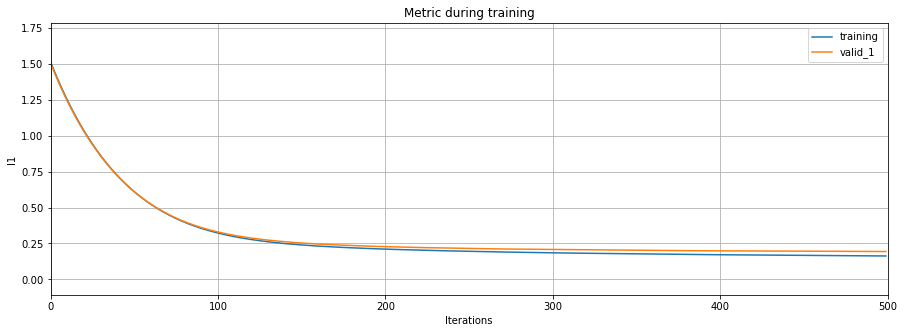

In [69]:
lgb.plot_metric(model)

In [70]:
# commit
df_test = df[~df.is_train].copy()
df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test = df_test[feats_eli].fillna(-1)
X_test= X_test.reset_index(drop=True)

df_test['weekly_sales'] = model.predict(X_test)
df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))

In [71]:
df_test[ ["id", "weekly_sales"] ].to_csv("../output/lgb_final.csv", index=False)

**Czy może być lepiej? RandomForrest**

Za długo się liczy, dlatego odpuszczam...

# ELI5

In [ ]:
# df_train = df[df.is_train].copy().sample(2000)
# df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# X = df_train[feats_all].fillna(-1).reset_index(drop=True)
# y = df_train[target].reset_index(drop=True)

In [ ]:
# model = RandomForestRegressor()
# model.fit(X, y)

# imp = PermutationImportance(model, random_state=2022, cv=ShuffleSplit(n_splits=3)).fit(X, y)

# eli5_weights = eli5.show_weights(imp, feature_names=feats_all, top=100)
# eli5_weights_table = pd.read_html(eli5_weights.data)[0].loc[:99,]
# eli5_weights_table['w'] = eli5_weights_table['Weight'].map(lambda x: np.float(x.split(' ')[0]) + np.float(x.split(' ')[-1]))
# eli5_weights_table = eli5_weights_table[eli5_weights_table.w.map(abs) > 0.001]
# eli5_weights

In [ ]:
# feats_eli = list(eli5_weights_table.sort_values('w', ascending=False)['Feature'][:30])
# feats_eli

In [ ]:
# feats_eli = [
#     'weekly_sales_store_dept_year_prev_log1p',
#     'dept',
#     'monthly_sales_store_type_std_year_prev_log1p',
#     'store_size',
#     'weekly_sales_store_type_std_year_prev_log1p',
#     'store_dept',
#     'dept_store_type_wk_cnt',
#     'monthly_sales_store_dept_mean_year_prev_log1p',
#     'dept_wk_cnt',
#     'monthly_sales_store_dept_sum_year_prev_log1p',
#     'store',
#     'weekly_sales_store_std_year_prev_log1p',
#     'weekly_sales_store_max_year_prev_log1p',
#     'monthly_sales_store_dept_min_year_prev_log1p',
#     'store_size_cat',
#     'monthly_sales_store_dept_median_year_prev_log1p',
#     'dept_store_type_mo_cnt',
#     'weekly_sales_store_size_max_year_prev_log1p',
#     'weekly_sales_store_mean_year_prev_log1p',
#     'year',
#     'week',
#     'dept_yr_cnt',
#     'dept_mo_cnt',
#     'weekly_sales_store_median_year_prev_log1p',
#     'monthly_sales_store_mean_year_prev_log1p',
#     'monthly_sales_store_max_year_prev_log1p',
#     'weekly_sales_store_size_year_prev_log1p',
#     'weekly_sales_store_size_std_year_prev_log1p',
#     'dept_store_type_yr_cnt',
#     'weekly_sales_store_type_max_year_prev_log1p',
#     'store_size_cat',
#     'dept_mo_cnt',
#     'week',
#     'month' ,
# ]

### Parameters Optimization

In [ ]:
# X = X[feats_eli]

In [ ]:
# def objective(trial, X=X, y=y, test_size=0.2):
#     train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=test_size, random_state=2022)
    
#     param = {
#         'criterion': trial.suggest_categorical('criterion', ['mae']),
#         'bootstrap': trial.suggest_categorical('bootstrap',['True','False']),
#         'max_depth': trial.suggest_int('max_depth', 1, 10000),
#         'max_features': trial.suggest_categorical('max_features', ['auto', 'sqrt','log2']),
#         'max_leaf_nodes': trial.suggest_int('max_leaf_nodes', 1, 10000),
#         'n_estimators': trial.suggest_int('n_estimators', 30, 1000) ,
#     }
#     model = RandomForestRegressor(**param)  
    
#     model.fit(train_x, train_y)
    
#     preds = model.predict(test_x)

#     mae = mean_absolute_error(test_y.map(lambda x: np.expm1(x)), list(map(lambda x: np.expm1(x), list(preds))))
    
#     return mae

In [ ]:
# study = optuna.create_study(direction='minimize')
# study.optimize(objective, n_trials=5)
# print('Number of finished trials:', len(study.trials))
# print('Best trial:', study.best_trial.params)

In [ ]:
# best_params = study.best_params
# best_params

In [ ]:
# best_params = {
#     'criterion': 'mae',
#     'bootstrap': 'True',
#     'max_depth': 4173,
#     'max_features': 'auto',
#     'max_leaf_nodes': 4402,
#     'n_estimators': 475
# }

### TEST + COMMIT

In [ ]:
# df_train = df[df.is_train].copy()
# df_train.replace([np.inf, -np.inf], np.nan, inplace=True)

# X = df_train[feats_all].fillna(-1).reset_index(drop=True)
# y = df_train[target].reset_index(drop=True)

# train_x, test_x, train_y, test_y = train_test_split(X, y, test_size=0.1, random_state=2022)

# model = RandomForestRegressor(**best_params)  
# model.fit(train_x, train_y)

In [ ]:
# preds = model.predict(test_x)
# mae = mean_absolute_error(test_y.map(lambda x: np.expm1(x)), list(map(lambda x: np.expm1(x), list(preds))))
# mae

In [ ]:
# # commit
# df_test = df[~df.is_train].copy()
# df_test.replace([np.inf, -np.inf], np.nan, inplace=True)
# X_test = df_test[feats_eli].fillna(-1)
# X_test= X_test.reset_index(drop=True)

# df_test['weekly_sales'] = model.predict(X_test)
# df_test['weekly_sales'] = df_test['weekly_sales'].map(lambda x: np.expm1(x))

In [ ]:
# df_test[ ["id", "weekly_sales"] ].to_csv("../output/random_forest_final.csv", index=False)